# WaveTilts Class [v1]

In [1]:
%matplotlib inline

In [2]:
# imports
import os
import numpy as np
from importlib import reload

from astropy.table import Table

from pypit import wavetilts

In [3]:
# Path to PYPIT-Development-suite
pypdev_path = os.getenv('PYPIT_DEV')

----

# Development

In [4]:
from pypit import traceslits
from pypit import arcimage

## Load up required MasterFrames

In [5]:
settings = dict(masters={})
settings['masters']['directory'] = pypdev_path+'/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/MF_shane_kast_blue'
settings['masters']['reuse'] = True

In [6]:
setup = 'A_01_aa'

### MasterArc

In [7]:
AImg = arcimage.ArcImage(setup=setup, settings=settings)
msarc, header, _ = AImg.load_master_frame()

[WARNING] :: processimages.py 97 __init__() - No information on the spectrograph was given.  Do not attempt to (re)process the images
[INFO]    :: armasters.py 241 _load() - Loading a pre-existing master calibration frame
[INFO]    :: armasters.py 243 _load() - Master arc frame loaded successfully:
             /data/Projects/Python/PYPIT-development-suite//REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/MF_shane_kast_blue/MasterArc_A_01_aa.fits


### TraceSlits

In [8]:
TSlits = traceslits.TraceSlits.from_master_files(settings['masters']['directory']+'/MasterTrace_A_01_aa')
TSlits._make_pixel_arrays()

[INFO]    :: traceslits.py 207 from_master_files() - Loading BPM from /data/Projects/Python/PYPIT-development-suite//REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/MF_shane_kast_blue/MasterTrace_A_01_aa.fits.gz
[INFO]    :: traceslits.py 518 _make_pixel_arrays() - Converting physical trace locations to nearest pixel
[INFO]    :: traceslits.py 525 _make_pixel_arrays() - Identifying the pixels belonging to each slit


----

## Init WaveTilts

In [239]:
reload(wavetilts)
waveTilts = wavetilts.WaveTilts(msarc, det=1, setup=setup, rordloc=TSlits.rcen, lordloc=TSlits.lcen, 
                             pixlocn=TSlits.pixlocn, pixcen=TSlits.pixcen)

[WARNING] :: masterframe.py 55 __init__() - MasterFrame class not proper loaded (e.g. no masters in settings).  Avoid using Master methods


## Extract arcs -- Requires msarc and slit info

In [240]:
arccen, maskslits = waveTilts._extract_arcs()

[INFO]    :: ararc.py 86 get_censpec() - Extracting an approximate arc spectrum at the centre of each slit


In [241]:
arccen.shape

(2048, 1)

## Tilts in this slit

In [242]:
slit=0

In [243]:
waveTilts.settings['tilts']['trthrsh'] = 500.  # Lowers the thershold amplitude of the arc lines used

trcdict = waveTilts._trace_tilts(slit)

[WORK IN ]::
[PROGRESS]:: artracewave.py 261 trace_tilt() - Detecting lines for slit 1
[INFO]    :: ararc.py 180 detect_lines() - Detecting lines
[INFO]    :: ararc.py 224 detect_lines() - Detecting the strongest, nonsaturated lines
[INFO]    :: artracewave.py 319 trace_tilt() - Modelling arc line tilts with 13 arc lines
[WORK IN ]::
[PROGRESS]:: artracewave.py 325 trace_tilt() - This next step could be multiprocessed to speed up the reduction
[INFO]    :: artracewave.py 523 trace_tilt() - Completed spectral tilt tracing


### Show

In [244]:
waveTilts.show('sslit', slit=slit)

[INFO]    :: wavetilts.py 238 show() - Green = ok line;  red=rejected


## Analyze the tilt traces in a single slit

In [245]:
waveTilts.settings['tilts']['order'] = 3

In [246]:
badrows = waveTilts._analyze_tilt_traces(slit)
badrows

0

## Prepare polytilts

In [247]:
waveTilts.all_trcdict[0]['arcdet']

array([  43,  168,  202,  245,  259,  496,  637,  658,  689,  804,  948,
        956,  967,  996, 1020, 1077, 1222, 1259, 1274, 1307, 1389, 1503,
       1590, 1655, 1718, 1998])

In [248]:
#mtilt = waveTilts.all_tilts[3]
#mtilt[:,0] * (waveTilts.msarc.shape[0]-1)

In [249]:
waveTilts.settings['tilts']['yorder'] = 3
waveTilts.settings['tilts']['poly_2Dfunc'] = 'legendre'
waveTilts.settings['tilts']['poly_2D'] = True

In [250]:
polytilts = waveTilts._prepare_polytilts(skip_QA=False, show_QA=True)

[WORK IN ]::
[PROGRESS]:: artracewave.py 868 prepare_polytilts() - May need to do a check here to make sure ofit is reasonable
[WARNING] :: artracewave.py 890 prepare_polytilts() - Could not perform a PCA when tracing the spectral tilt
             Not enough well-traced arc lines
[INFO]    :: artracewave.py 891 prepare_polytilts() - Fitting tilts with a low order, 2D legendre
[WORK IN ]::
[PROGRESS]:: arutils.py 631 polyfit2d_general() - Generalize to different polynomial types


### Show image

In [233]:
waveTilts.show('polytilt_img')

### Show on arc lines

In [234]:
waveTilts.show('polytilts', slit=slit)

In [235]:
waveTilts.show('model', slit=slit)

[INFO]    :: wavetilts.py 244 show() - Ignore the color scheme


#### Not so well traced on the left edge
    Try increasing the order

## spca

In [251]:
waveTilts._tilts_spca(slit)

[INFO]    :: artracewave.py 1034 tilts_spca() - Performing a spca analysis of the tilts
[WORK IN ]::
[PROGRESS]:: artracewave.py 1060 tilts_spca() - Consider adding weights to SmoothBivariate in spca


In [252]:
waveTilts.show('tilts', slit=slit)

## Output

In [57]:
waveTilts.save_master('tmp.fits', use_tilts_as_final=True)

[WARNING] :: wavetilts.py 277 save_master() - Using tilts as final.  Better know what you are doing!


> /data/Projects/Python/PYPIT/pypit/wavetilts.py(295)save_master()
-> mcnt = 0
(Pdb) c
> /data/Projects/Python/PYPIT/pypit/wavetilts.py(287)save_master()
-> for slit in range(self.nslit):
(Pdb) self.nslit
1
(Pdb) c


### Increase order

In [152]:
waveTilts.settings['tilts']['order'] = 3

In [153]:
badrows = waveTilts._analyze_tilt_traces(slit)
badrows

0

[WORK IN ]::
[PROGRESS]:: artracewave.py 852 prepare_polytilts() - May need to do a check here to make sure ofit is reasonable
[INFO]    :: artracewave.py 858 prepare_polytilts() - Performing a PCA on the tilts
               Reduced chi-squared = 1.192590E-11


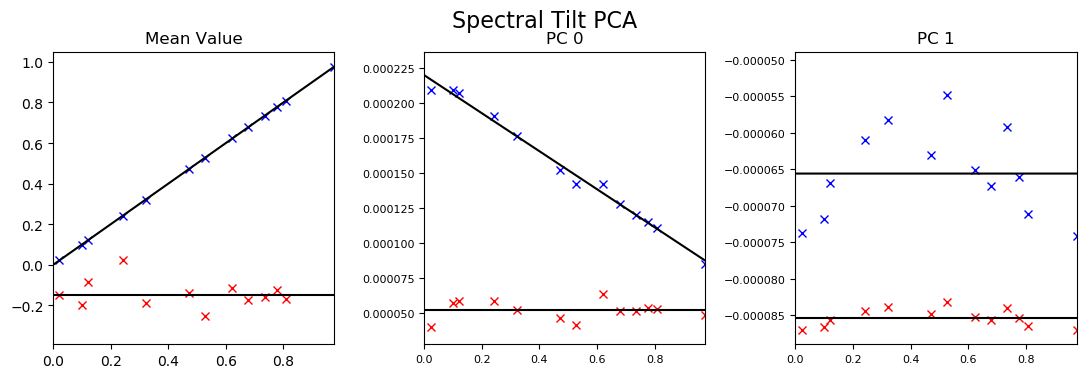

In [112]:
polytilts = waveTilts._prepare_polytilts(skip_QA=False, show_QA=True)

In [113]:
waveTilts.show('model2', slit=slit)

### Looks the same

### Increase params

In [114]:
waveTilts.settings['tilts']['params'], waveTilts.settings['tilts']['order'] 

([1, 1, 0], 3)

In [75]:
waveTilts.settings['tilts']['params'] = [2,1,0]

[WORK IN ]::
[PROGRESS]:: artracewave.py 847 prepare_polytilts() - May need to do a check here to make sure ofit is reasonable
[INFO]    :: artracewave.py 853 prepare_polytilts() - Performing a PCA on the tilts
               Reduced chi-squared = 8.816021E-11


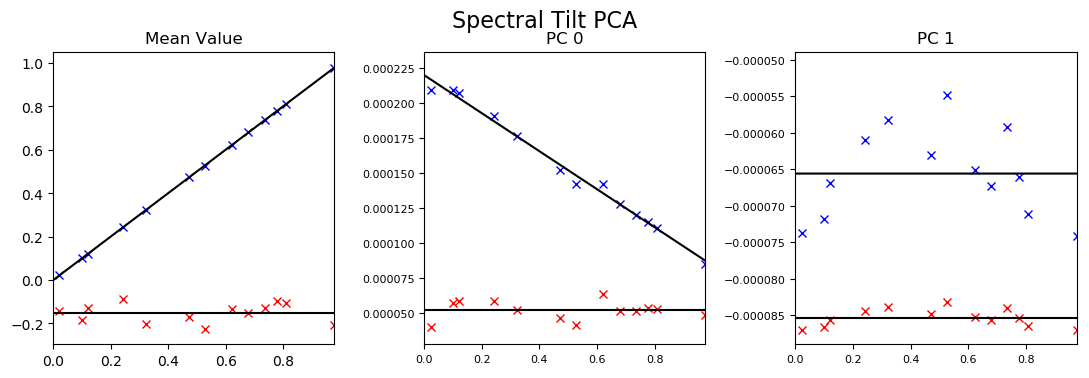

In [76]:
polytilts = waveTilts._prepare_polytilts(skip_QA=False, show_QA=True)

In [121]:
waveTilts.show('polytilts', slit=slit)

#### Still no improvement..

In [78]:
waveTilts.outpar

{'coeffstr': [array([  1.52135806e-04,  -6.79569450e-05]),
  array([ -6.55849153e-05])],
 'eigv': array([[-1.41244458,  0.0707129 ],
        [-1.3958874 ,  0.07796363],
        [-1.37940328,  0.08514826],
        [-1.36299223,  0.0922668 ],
        [-1.34665424,  0.09931924],
        [-1.3303893 ,  0.10630559],
        [-1.31419743,  0.11322585],
        [-1.29807862,  0.12008001],
        [-1.28203288,  0.12686807],
        [-1.26606019,  0.13359005],
        [-1.25016056,  0.14024592],
        [-1.234334  ,  0.1468357 ],
        [-1.2185805 ,  0.15335939],
        [-1.20290006,  0.15981698],
        [-1.18729268,  0.16620848],
        [-1.17175836,  0.17253388],
        [-1.1562971 ,  0.17879319],
        [-1.14090891,  0.18498641],
        [-1.12559377,  0.19111353],
        [-1.1103517 ,  0.19717455],
        [-1.09518269,  0.20316948],
        [-1.08008674,  0.20909832],
        [-1.06506385,  0.21496106],
        [-1.05011402,  0.2207577 ],
        [-1.03523725,  0.22648826],
   

In [79]:
waveTilts.settings['tilts']['params'] 

[2, 1, 0]

In [147]:
waveTilts.settings['tilts']['method'] 

'spca'

[WORK IN ]::
[PROGRESS]:: artracewave.py 852 prepare_polytilts() - May need to do a check here to make sure ofit is reasonable
[INFO]    :: artracewave.py 858 prepare_polytilts() - Performing a PCA on the tilts
               Reduced chi-squared = 1.854099E-11


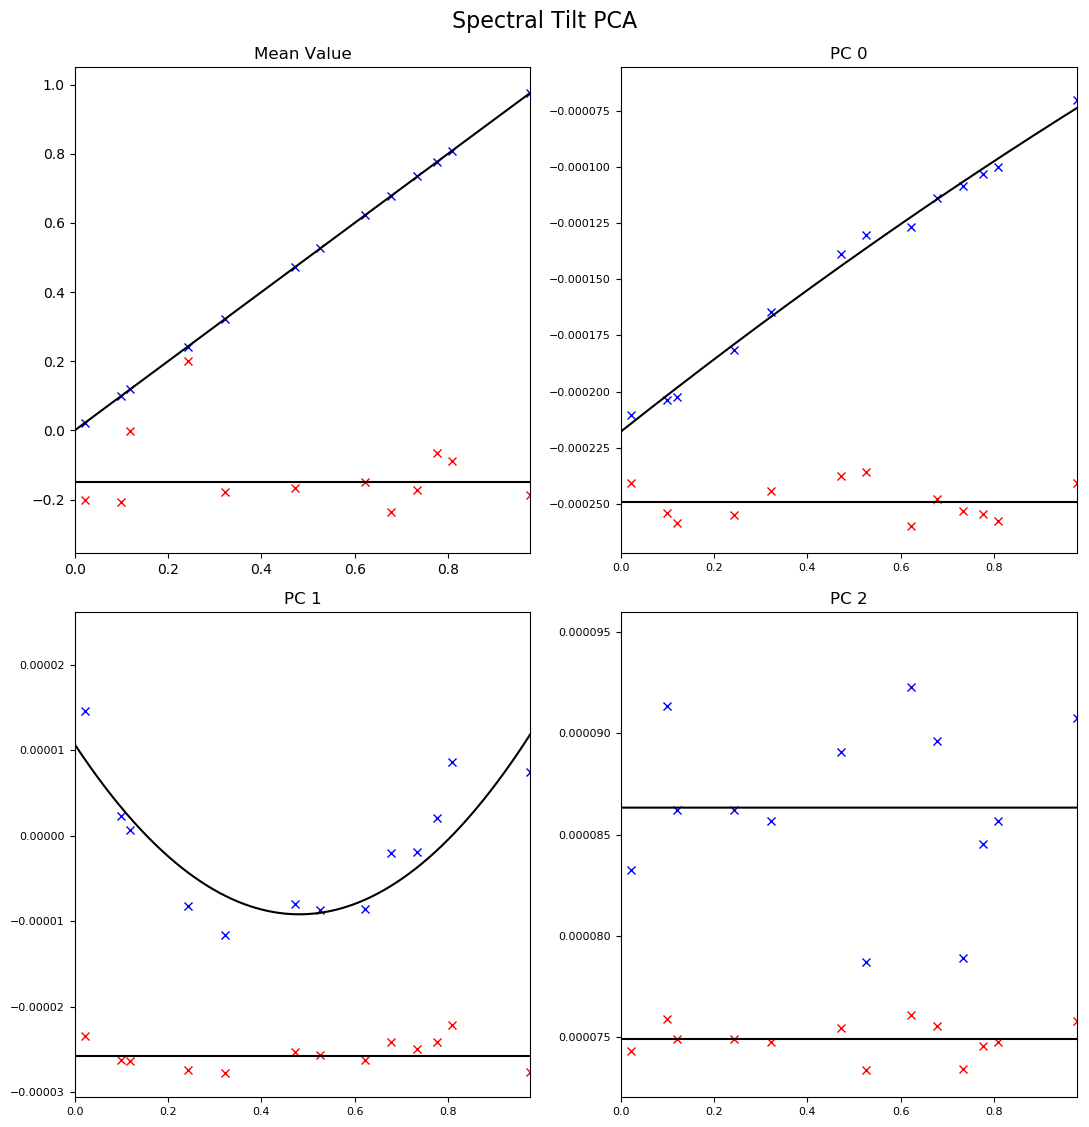

In [155]:
waveTilts.settings['tilts']['params'] = [3,2,2,0]
polytilts = waveTilts._prepare_polytilts(skip_QA=False, show_QA=True)

In [145]:
waveTilts.show('polytilts', slit=slit)

[INFO]    :: artracewave.py 1057 prep_tilts_qa() - Preparing arc tilt QA data


In [146]:
waveTilts.show('model2', slit=slit)

### spca me

In [156]:
waveTilts._tilts_spca(slit)

[INFO]    :: artracewave.py 1008 tilts_spca() - Performing a spca analysis of the tilts
[WORK IN ]::
[PROGRESS]:: artracewave.py 1033 tilts_spca() - Consider adding weights to SmoothBivariate in spca


In [157]:
waveTilts.show('tilts', slit=slit)

[INFO]    :: artracewave.py 1057 prep_tilts_qa() - Preparing arc tilt QA data


----

# DEIMOS long-slit

In [253]:
from pypit import traceslits
from pypit import arcimage

In [257]:
# Master frames
settings = dict(masters={})
settings['masters']['directory'] = pypdev_path+'/REDUX_OUT/Keck_DEIMOS/830G_L/MF_keck_deimos'
settings['masters']['reuse'] = True
setup = 'A_07_aa'

In [260]:
AImg = arcimage.ArcImage(setup=setup, settings=settings)
msarc, header, _ = AImg.load_master_frame()
#
TSlits = traceslits.TraceSlits.from_master_files(settings['masters']['directory']+'/MasterTrace_A_07_aa')
TSlits._make_pixel_arrays()

[WARNING] :: processimages.py 97 __init__() - No information on the spectrograph was given.  Do not attempt to (re)process the images
[INFO]    :: armasters.py 241 _load() - Loading a pre-existing master calibration frame
[INFO]    :: armasters.py 243 _load() - Master arc frame loaded successfully:
             /data/Projects/Python/PYPIT-development-suite//REDUX_OUT/Keck_DEIMOS/830G_L/MF_keck_deimos/MasterArc_A_07_aa.fits
[INFO]    :: traceslits.py 207 from_master_files() - Loading BPM from /data/Projects/Python/PYPIT-development-suite//REDUX_OUT/Keck_DEIMOS/830G_L/MF_keck_deimos/MasterTrace_A_07_aa.fits.gz
[INFO]    :: traceslits.py 518 _make_pixel_arrays() - Converting physical trace locations to nearest pixel
[INFO]    :: traceslits.py 525 _make_pixel_arrays() - Identifying the pixels belonging to each slit


----

In [314]:
reload(wavetilts)
waveTilts = wavetilts.WaveTilts(msarc, det=1, setup=setup, rordloc=TSlits.rcen, lordloc=TSlits.lcen, 
                             pixlocn=TSlits.pixlocn, pixcen=TSlits.pixcen)

[WARNING] :: masterframe.py 55 __init__() - MasterFrame class not proper loaded (e.g. no masters in settings).  Avoid using Master methods


In [315]:
arccen, maskslits = waveTilts._extract_arcs()

[INFO]    :: ararc.py 86 get_censpec() - Extracting an approximate arc spectrum at the centre of each slit


In [316]:
slit=0
waveTilts.settings['tilts']['trthrsh'] = 400.

In [317]:
# Trace tilts
trcdict = waveTilts._trace_tilts(slit)

[WORK IN ]::
[PROGRESS]:: artracewave.py 261 trace_tilt() - Detecting lines for slit 1
[INFO]    :: ararc.py 180 detect_lines() - Detecting lines
[INFO]    :: ararc.py 224 detect_lines() - Detecting the strongest, nonsaturated lines
[INFO]    :: artracewave.py 319 trace_tilt() - Modelling arc line tilts with 28 arc lines
[WORK IN ]::
[PROGRESS]:: artracewave.py 325 trace_tilt() - This next step could be multiprocessed to speed up the reduction
[INFO]    :: artracewave.py 523 trace_tilt() - Completed spectral tilt tracing


In [295]:
waveTilts.show('sslit', slit=slit)

[INFO]    :: wavetilts.py 238 show() - Green = ok line;  red=rejected


In [318]:
# Analyze tilts
waveTilts.settings['tilts']['order'] = 3
badrows = waveTilts._analyze_tilt_traces(slit)
badrows

[WARNING] :: wavetilts.py 125 _analyze_tilt_traces() - There were 2 additional arc lines that should have been traced
             (perhaps lines were saturated?). Check the spectral tilt solution


2

In [308]:
waveTilts.show('model', slit=slit)

[INFO]    :: wavetilts.py 244 show() - Ignore the color scheme


In [319]:
# Polytilts
waveTilts.settings['tilts']['order'] = 4
waveTilts.settings['tilts']['yorder'] = 4
waveTilts.settings['tilts']['poly_2Dfunc'] = 'legendre'
waveTilts.settings['tilts']['poly_2D'] = True

In [320]:
polytilts = waveTilts._prepare_polytilts()

[WORK IN ]::
[PROGRESS]:: artracewave.py 869 prepare_polytilts() - May need to do a check here to make sure ofit is reasonable
[WARNING] :: artracewave.py 891 prepare_polytilts() - Could not perform a PCA when tracing the spectral tilt
             Not enough well-traced arc lines
[INFO]    :: artracewave.py 892 prepare_polytilts() - Fitting tilts with a low order, 2D legendre
[WORK IN ]::
[PROGRESS]:: arutils.py 631 polyfit2d_general() - Generalize to different polynomial types


In [313]:
waveTilts.show('polytilts', slit=slit)

In [327]:
waveTilts.all_tilts[3][1497,28]

969.3390724416479

In [329]:
waveTilts.all_trcdict[0]['ytfit'][28][1497]

969.4705616135658

In [349]:
# jxp_spline
waveTilts._tilts_jxp_spline(slit)

[INFO]    :: artracewave.py 988 tilts_spline() - Performing a spline fit to the tilts


ValueError: Error code returned by bispev: 10

In [ ]:
# spca
waveTilts._tilts_spca(slit)

[INFO]    :: artracewave.py 1044 tilts_spca() - Performing a spca analysis of the tilts
[WORK IN ]::
[PROGRESS]:: artracewave.py 1071 tilts_spca() - Consider adding weights to SmoothBivariate in spca


[[3848496.17417425 3851931.02272896]
 [3848291.22121755 3851726.06074476]
 [3848086.14553921 3851520.97603335]
 [3847880.94714225 3851315.76859776]
 [3847675.62602968 3851110.43844099]
 [3847470.18220451 3850904.98556606]
 [3847264.61566975 3850699.40997598]
 [3847058.92642842 3850493.71167378]
 [3846853.11448354 3850287.89066246]] 940.0


[WORK IN ]::
[PROGRESS]:: arutils.py 631 polyfit2d_general() - Generalize to different polynomial types


[[939.80896246 939.75891682 939.70884124 939.6587357  939.60860021
  939.55843477 939.50823939 939.45801406 939.40775878]
 [940.64776025 940.59771239 940.54763458 940.49752682 940.44738911
  940.39722144 940.34702383 940.29679627 940.24653876]]
> /data/Projects/Python/PYPIT/pypit/core/artracewave.py(1095)tilts_spca()
-> return tilts
(Pdb) polytlits[1497,940]
*** NameError: name 'polytlits' is not defined
(Pdb) polytilts[1479,940]
0.3626103467688827
(Pdb) polytilts[1497,940]*(msarc.shape[0]-1)
1502.8987750507067
(Pdb) polytilts.shape
(4096, 2048)
(Pdb) polytilts[940,1497]*(msarc.shape[0]-1)
968.9762731250482
(Pdb) arcdet[28]
940


In [325]:
waveTilts.show('tilts', slit=slit)